In [1]:
!pip install findspark
!pip install pyspark
!pip install pyarrow
!pip install fastparquet
!pip install plotly

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 317.0/317.0 MB 3.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
  Created wheel for pyspark: filename=pyspark-3.5.1-py2.py3-none-any.whl size=317488491 sha256=77bfe3f94764c2b664264fe334e44dd4034d9707e3e2db06bdf9b3d2a188d410
  Stored in directory: /root/.cache/pip/wheels/80/1d/60/2c256ed38dddce2fdd93be545214a63e02fbd8d74fb0b7f3a6
Successfully built pyspark
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.7/1.7 MB 24.7 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 62.8 MB/s eta 0:00:00


In [2]:
# Importing our dependencies
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import pandas as pd
import tensorflow as tf

In [3]:
# Installing Java and Spark and starting a SparkSession
import os

spark_version = 'spark-3.5.1'
os.environ['SPARK_VERSION']=spark_version

# Installing Spark and Java
!apt-get update
!apt-get install openjdk-11-jdk-headless -qq > /dev/null
!wget -q http://www.apache.org/dist/spark/spark-3.5.1/spark-3.5.1-bin-hadoop3.tgz
!tar xf $SPARK_VERSION-bin-hadoop3.tgz
!pip install -q findspark

# Setting Environment Variables
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-11-openjdk-amd64"
os.environ["SPARK_HOME"] = f"/content/{spark_version}-bin-hadoop3"

# Starting a SparkSession
import findspark
findspark.init()

Hit:1 http://archive.ubuntu.com/ubuntu jammy InRelease
Get:2 http://archive.ubuntu.com/ubuntu jammy-updates InRelease [119 kB]
Get:3 https://cloud.r-project.org/bin/linux/ubuntu jammy-cran40/ InRelease [3,626 B]
Hit:4 http://archive.ubuntu.com/ubuntu jammy-backports InRelease
Hit:5 https://developer.download.nvidia.com/compute/cuda/repos/ubuntu2204/x86_64  InRelease
Get:6 http://security.ubuntu.com/ubuntu jammy-security InRelease [110 kB]
Hit:7 https://ppa.launchpadcontent.net/c2d4u.team/c2d4u4.0+/ubuntu jammy InRelease
Get:8 http://archive.ubuntu.com/ubuntu jammy-updates/main amd64 Packages [2,043 kB]
Hit:9 https://ppa.launchpadcontent.net/deadsnakes/ppa/ubuntu jammy InRelease
Get:10 http://archive.ubuntu.com/ubuntu jammy-updates/restricted amd64 Packages [2,347 kB]
Hit:11 https://ppa.launchpadcontent.net/graphics-drivers/ppa/ubuntu jammy InRelease
Hit:12 https://ppa.launchpadcontent.net/ubuntugis/ppa/ubuntu jammy InRelease
Get:13 http://security.ubuntu.com/ubuntu jammy-security/unive

In [4]:
# Import packages
from pyspark.sql import SparkSession
import time

# Create a SparkSession
spark = SparkSession.builder.appName("SparkSQL").getOrCreate()

/usr/lib/python3.10/subprocess.py:1796: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = _posixsubprocess.fork_exec(


In [5]:
spark

In [6]:
# 1. Reading in the AWS S3 bucket into a DataFrame.
from pyspark import SparkFiles
url = "https://heart-2022-no-nans.s3.us-east-2.amazonaws.com/heart_2022_no_nans.csv"
spark.sparkContext.addFile(url)
heart_disease_df = spark.read.csv(SparkFiles.get("heart_2022_no_nans.csv"), sep=",", header=True)
heart_disease_df.show()

+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+--------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+--------------------+----------------+--------+
|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|SleepHours|        RemovedTeeth|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDress

In [7]:
# 2. Creating a temporary view of the DataFrame.
heart_disease_df.createOrReplaceTempView("heart_disease_temp_view")

In [8]:
# Describing the DataFrame
heart_disease_df.describe()

DataFrame[summary: string, State: string, Sex: string, GeneralHealth: string, PhysicalHealthDays: string, MentalHealthDays: string, LastCheckupTime: string, PhysicalActivities: string, SleepHours: string, RemovedTeeth: string, HadHeartAttack: string, HadAngina: string, HadStroke: string, HadAsthma: string, HadSkinCancer: string, HadCOPD: string, HadDepressiveDisorder: string, HadKidneyDisease: string, HadArthritis: string, HadDiabetes: string, DeafOrHardOfHearing: string, BlindOrVisionDifficulty: string, DifficultyConcentrating: string, DifficultyWalking: string, DifficultyDressingBathing: string, DifficultyErrands: string, SmokerStatus: string, ECigaretteUsage: string, ChestScan: string, RaceEthnicityCategory: string, AgeCategory: string, HeightInMeters: string, WeightInKilograms: string, BMI: string, AlcoholDrinkers: string, HIVTesting: string, FluVaxLast12: string, PneumoVaxEver: string, TetanusLast10Tdap: string, HighRiskLastYear: string, CovidPos: string]

In [9]:
# Showing schema for the DataFrame
heart_disease_df.printSchema()

root
 |-- State: string (nullable = true)
 |-- Sex: string (nullable = true)
 |-- GeneralHealth: string (nullable = true)
 |-- PhysicalHealthDays: string (nullable = true)
 |-- MentalHealthDays: string (nullable = true)
 |-- LastCheckupTime: string (nullable = true)
 |-- PhysicalActivities: string (nullable = true)
 |-- SleepHours: string (nullable = true)
 |-- RemovedTeeth: string (nullable = true)
 |-- HadHeartAttack: string (nullable = true)
 |-- HadAngina: string (nullable = true)
 |-- HadStroke: string (nullable = true)
 |-- HadAsthma: string (nullable = true)
 |-- HadSkinCancer: string (nullable = true)
 |-- HadCOPD: string (nullable = true)
 |-- HadDepressiveDisorder: string (nullable = true)
 |-- HadKidneyDisease: string (nullable = true)
 |-- HadArthritis: string (nullable = true)
 |-- HadDiabetes: string (nullable = true)
 |-- DeafOrHardOfHearing: string (nullable = true)
 |-- BlindOrVisionDifficulty: string (nullable = true)
 |-- DifficultyConcentrating: string (nullable = t

In [55]:
# Replacing "Yes" with 1 and "No" with 0 in the specified columns

from pyspark.sql.functions import when

# Replacing specified columns in the DataFrame
columns_to_replace = ["HadHeartAttack", "HadAngina", "HadStroke", "HadAsthma", "HadSkinCancer",
                      "HadCOPD", "HadDepressiveDisorder", "HadKidneyDisease", "HadArthritis",
                      "HadDiabetes", "DeafOrHardOfHearing", "BlindOrVisionDifficulty",
                      "DifficultyConcentrating", "DifficultyWalking", "DifficultyDressingBathing",
                      "DifficultyErrands", "AlcoholDrinkers", "HIVTesting", "FluVaxLast12",
                      "PneumoVaxEver", "TetanusLast10Tdap", "HighRiskLastYear", "CovidPos"]

for column in columns_to_replace:
    heart_disease_df = heart_disease_df.withColumn(column, when(heart_disease_df[column] == "Yes", 1).otherwise(0))

# Showing the DataFrame with replaced values
heart_disease_df.show()


+-------+------+-------------+------------------+----------------+--------------------+------------------+----------+--------------------+--------------+---------+---------+---------+-------------+-------+---------------------+----------------+------------+-----------+-------------------+-----------------------+-----------------------+-----------------+-------------------------+-----------------+--------------------+--------------------+---------+---------------------+---------------+--------------+-----------------+-----+---------------+----------+------------+-------------+-----------------+----------------+--------+
|  State|   Sex|GeneralHealth|PhysicalHealthDays|MentalHealthDays|     LastCheckupTime|PhysicalActivities|SleepHours|        RemovedTeeth|HadHeartAttack|HadAngina|HadStroke|HadAsthma|HadSkinCancer|HadCOPD|HadDepressiveDisorder|HadKidneyDisease|HadArthritis|HadDiabetes|DeafOrHardOfHearing|BlindOrVisionDifficulty|DifficultyConcentrating|DifficultyWalking|DifficultyDressing

In [11]:
# Cleaning data by searching for missing values within the DataFrame

from pyspark.sql.functions import col

# List columns with missing values
columns_with_missing_values = [col_name for col_name in heart_disease_df.columns if heart_disease_df.where(col(col_name).isNull()).count() > 0]

# Show columns with missing values
print("Columns with missing values:")
if columns_with_missing_values:
    print(", ".join(columns_with_missing_values))
else:
    print("No columns have missing values.")



Columns with missing values:
No columns have missing values.


In [12]:
# Looking for duplicate rows in the Dataset and Removing them

# Removing duplicate rows from the DataFrame
cleaned_df = heart_disease_df.dropDuplicates()

# Checking the shape of the cleaned DataFrame
print("Shape of cleaned DataFrame:", (cleaned_df.count(), len(cleaned_df.columns)))


Shape of cleaned DataFrame: (246004, 40)


In [14]:
# 1. Are males or females more likely to be at risk for heart disease?

from pyspark.sql import functions as F

# Grouping by 'Sex' column and count the occurrences
count_by_sex = heart_disease_df.groupBy('Sex').count()

# Showing the count for each sex
count_by_sex.show()

# Grouping by 'Sex' column and sum the occurrences of 'HadHeartAttack'
risk_by_sex = heart_disease_df.groupBy('Sex').agg(F.sum('HadHeartAttack').alias('TotalHeartAttacks'))

# Showing the total heart attacks for each sex
risk_by_sex.show()

# Determining which gender has a higher total heart attacks
male_heart_attacks = risk_by_sex.filter(risk_by_sex['Sex'] == 'Male').select('TotalHeartAttacks').collect()[0][0]
female_heart_attacks = risk_by_sex.filter(risk_by_sex['Sex'] == 'Female').select('TotalHeartAttacks').collect()[0][0]

# Showing the results of who is more likely to be at risk for heart disease
if male_heart_attacks > female_heart_attacks:
    print("Males are more likely to be at risk for heart disease.")
elif female_heart_attacks > male_heart_attacks:
    print("Females are more likely to be at risk for heart disease.")
else:
    print("Males and females are equally likely to be at risk for heart disease.")



+------+------+
|   Sex| count|
+------+------+
|Female|127811|
|  Male|118211|
+------+------+

+------+-----------------+
|   Sex|TotalHeartAttacks|
+------+-----------------+
|Female|             4932|
|  Male|             8503|
+------+-----------------+

Males are more likely to be at risk for heart disease.


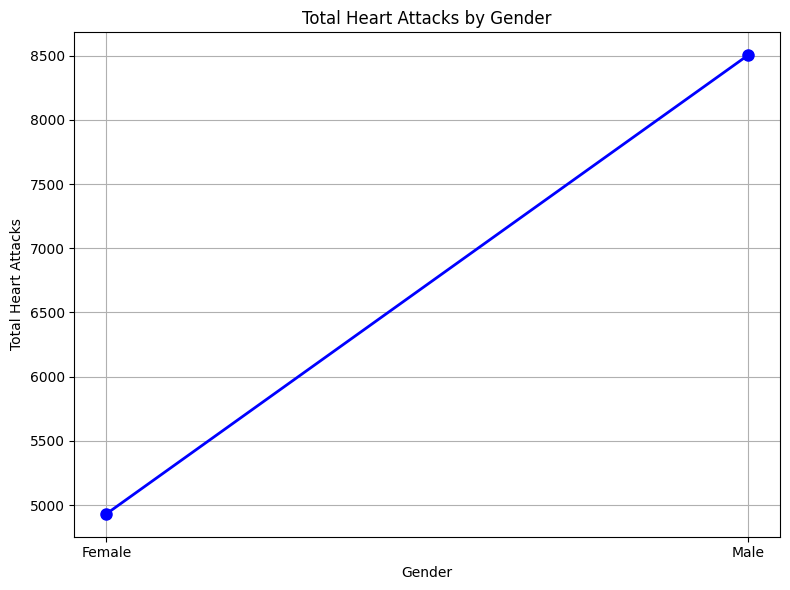

In [64]:
import matplotlib.pyplot as plt

# Gender labels and corresponding total heart attacks
genders = ['Female', 'Male']
heart_attacks = [4932, 8503]  # Total heart attacks for each gender

# Create the line plot
plt.figure(figsize=(8, 6))
plt.plot(genders, heart_attacks, marker='o', color='blue', linestyle='-', linewidth=2, markersize=8)

# Adding labels and title
plt.xlabel('Gender')
plt.ylabel('Total Heart Attacks')
plt.title('Total Heart Attacks by Gender')

# Display the plot
plt.grid(True)
plt.tight_layout()
plt.show()



In [15]:
# 2. How does age factor in to heart disease risk?

# Creating a temporary view of the DataFrame
heart_disease_df.createOrReplaceTempView("heart_disease")

# Writing a SQL query to calculate the average age for individuals at risk for heart disease
sql_query = """
    SELECT AgeCategory, AVG(HadHeartAttack) * 100 AS AverageHeartDiseaseRisk
    FROM heart_disease
    GROUP BY AgeCategory
    ORDER BY AgeCategory;
"""
# Executing the SQL query
avg_age_at_risk = spark.sql(sql_query)

# Showing the SQL query results
avg_age_at_risk.show()

+---------------+-----------------------+
|    AgeCategory|AverageHeartDiseaseRisk|
+---------------+-----------------------+
|   Age 18 to 24|     0.3810394756896815|
|   Age 25 to 29|    0.42308038527320185|
|   Age 30 to 34|     0.6743593586093212|
|   Age 35 to 39|     0.9991033687716153|
|   Age 40 to 44|     1.3433099628822247|
|   Age 45 to 49|      2.507013669193577|
|   Age 50 to 54|     3.5303570531813393|
|   Age 55 to 59|      5.003599712023038|
|   Age 60 to 64|      5.894461077844312|
|   Age 65 to 69|      7.546310886997934|
|   Age 70 to 74|      9.355452814794669|
|   Age 75 to 79|     11.386193206881341|
|Age 80 or older|     13.616973506960036|
+---------------+-----------------------+



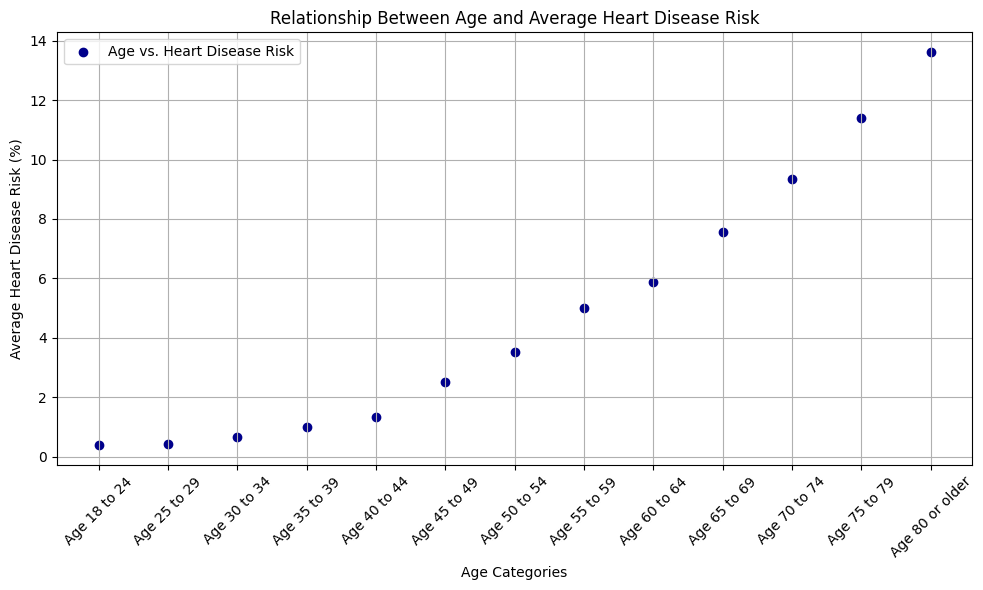

In [67]:
import matplotlib.pyplot as plt

# Age categories and corresponding average heart disease risk
age_categories = ['Age 18 to 24', 'Age 25 to 29', 'Age 30 to 34', 'Age 35 to 39', 'Age 40 to 44',
                  'Age 45 to 49', 'Age 50 to 54', 'Age 55 to 59', 'Age 60 to 64', 'Age 65 to 69',
                  'Age 70 to 74', 'Age 75 to 79', 'Age 80 or older']
heart_disease_risk = [0.38, 0.42, 0.67, 1.00, 1.34, 2.51, 3.53, 5.00, 5.89, 7.55, 9.36, 11.39, 13.62]  # Average heart disease risk

# Create the scatter plot with darker dots
plt.figure(figsize=(10, 6))
plt.scatter(age_categories, heart_disease_risk, color='darkblue', label='Age vs. Heart Disease Risk')

# Adding labels and title
plt.xlabel('Age Categories')
plt.ylabel('Average Heart Disease Risk (%)')
plt.title('Relationship Between Age and Average Heart Disease Risk')

# Display the plot
plt.xticks(rotation=45)  # Rotate x-axis labels for better readability
plt.grid(True)
plt.tight_layout()
plt.legend()
plt.show()



In [16]:
# 3_a. How many of each Race/Ethnicity exsist in the DataFrame?

# Creating a temporary viewof the DataFrame
heart_disease_df.createOrReplaceTempView("Race_Ethnicity")

# Writing a SQL query to calculate the count of the different Race/Ethnicities in the DataFrame
sql_query = """
    SELECT RaceEthnicityCategory, COUNT(*) AS Count
    FROM Race_Ethnicity
    GROUP BY RaceEthnicityCategory;
"""
# Executing the SQL query
Race_Ethnicity_count= spark.sql(sql_query)

# Showing the SQL query results
Race_Ethnicity_count.show()


+---------------------+------+
|RaceEthnicityCategory| Count|
+---------------------+------+
| Black only, Non-H...| 19330|
| Other race only, ...| 12205|
| Multiracial, Non-...|  5581|
|             Hispanic| 22570|
| White only, Non-H...|186336|
+---------------------+------+



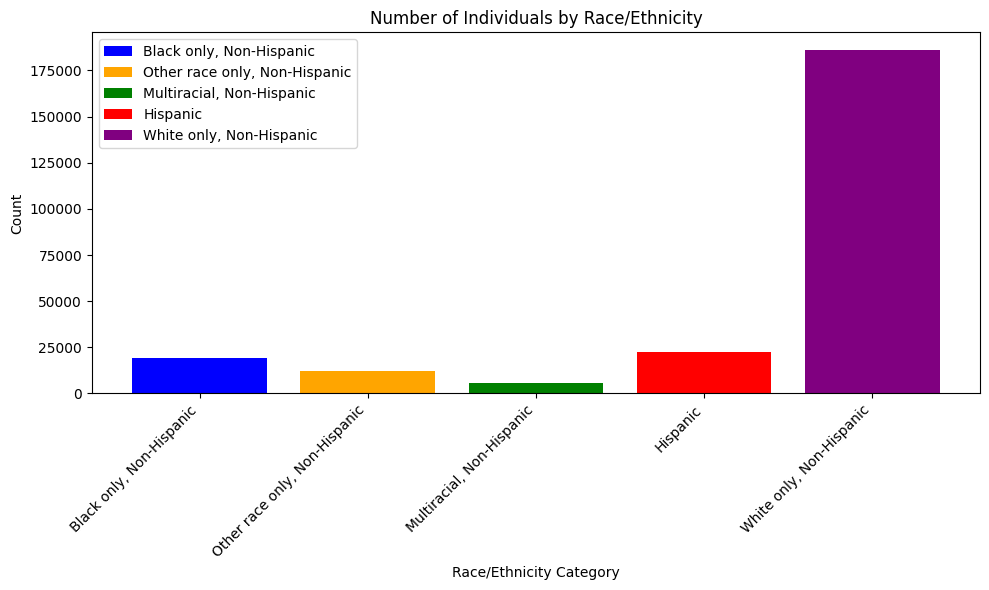

In [77]:
import matplotlib.pyplot as plt

# Extracting data from the DataFrame
categories = Race_Ethnicity_count.select("RaceEthnicityCategory").rdd.flatMap(lambda x: x).collect()
counts = Race_Ethnicity_count.select("Count").rdd.flatMap(lambda x: x).collect()

# Define colors for each category
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Creating the bar plot with consistent colors for each category
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, counts, color=colors)
plt.xlabel('Race/Ethnicity Category')
plt.ylabel('Count')
plt.title('Number of Individuals by Race/Ethnicity')

# Add a legend for the colors
plt.legend(bars, categories, loc='upper left')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()




In [17]:
# 3_b. How does Race/Ethnicity factor in to heart disease risk?

# Writing a SQL query to show heart disease prevalence according to Race/Ethnicity on average
sql_query = """
    SELECT
        RaceEthnicityCategory,
        AVG(CASE WHEN HadHeartAttack = 1 THEN 1 ELSE 0 END) * 100 AS HeartDiseasePrevalence
    FROM
        Race_Ethnicity
    GROUP BY
        RaceEthnicityCategory
    ORDER BY
        RaceEthnicityCategory;
"""

# Executing the SQL query
Race_Ethnicity_at_risk = spark.sql(sql_query)

# Showing the SQL query results
Race_Ethnicity_at_risk.show()



+---------------------+----------------------+
|RaceEthnicityCategory|HeartDiseasePrevalence|
+---------------------+----------------------+
| Black only, Non-H...|    4.5990688049663735|
|             Hispanic|    3.8059370846256093|
| Multiracial, Non-...|     6.092098190288478|
| Other race only, ...|     4.842277755018435|
| White only, Non-H...|    5.7723681950884425|
+---------------------+----------------------+



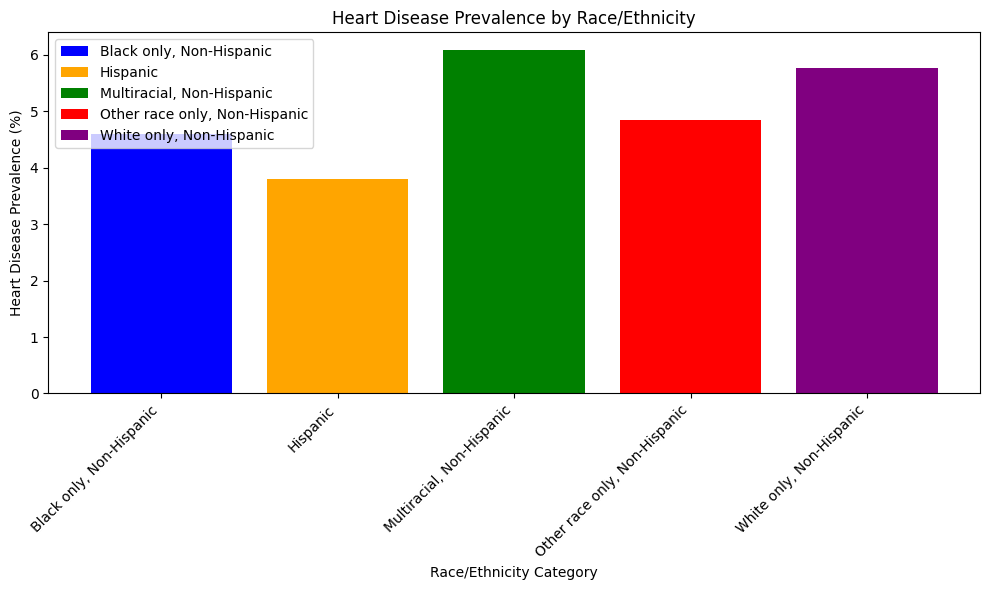

In [75]:
import matplotlib.pyplot as plt

# Extracting data from the DataFrame
categories = Race_Ethnicity_at_risk.select("RaceEthnicityCategory").rdd.flatMap(lambda x: x).collect()
prevalence = Race_Ethnicity_at_risk.select("HeartDiseasePrevalence").rdd.flatMap(lambda x: x).collect()

# Define colors for each category
colors = ['blue', 'orange', 'green', 'red', 'purple']

# Creating the bar plot with consistent colors for each category
plt.figure(figsize=(10, 6))
bars = plt.bar(categories, prevalence, color=colors)
plt.xlabel('Race/Ethnicity Category')
plt.ylabel('Heart Disease Prevalence (%)')
plt.title('Heart Disease Prevalence by Race/Ethnicity')

# Add a legend for the colors
plt.legend(bars, categories, loc='upper left')

plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()



In [22]:
# 4. How do the BMI(Body Mass Index) values impact risk for heat disease?

# Creating a temporary viewof the DataFrame

heart_disease_df.createOrReplaceTempView("BMI")

sql_query = """
    SELECT
        AVG(BMI) AS AverageBMI,
        AVG(HadHeartAttack) AS HeartDiseasePrevalence
    FROM
        BMI
    GROUP BY
        HadHeartAttack;

"""

# Executing the SQL query
bmi_numb_at_risk = spark.sql(sql_query)

# Showing the SQL query results
bmi_numb_at_risk.show()


+------------------+----------------------+
|        AverageBMI|HeartDiseasePrevalence|
+------------------+----------------------+
|29.492435429847518|                   1.0|
|28.620521482282513|                   0.0|
+------------------+----------------------+



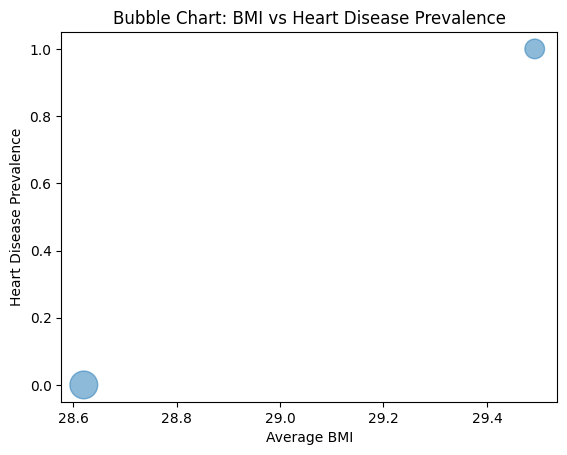

In [79]:
import matplotlib.pyplot as plt

# Sample data
average_bmi = [29.492435429847518, 28.620521482282513]
heart_disease_prevalence = [1.0, 0.0]

# Sizes of the bubbles
bubble_sizes = [200, 400]

# Create the bubble chart
plt.scatter(average_bmi, heart_disease_prevalence, s=bubble_sizes, alpha=0.5)

# Add labels and title
plt.xlabel('Average BMI')
plt.ylabel('Heart Disease Prevalence')
plt.title('Bubble Chart: BMI vs Heart Disease Prevalence')

# Show the plot
plt.show()


In [29]:
# 5. Does smoking have an impact on your risk of heart disease?

heart_disease_df.createOrReplaceTempView("HeartData")

# SQL query to calculate heart disease prevalence by smoking status
sql_query = """
SELECT SmokerStatus,
       AVG(CASE WHEN HadHeartAttack = 1 THEN 1 ELSE 0 END) * 100 AS HeartDiseasePrevalence
FROM HeartData
GROUP BY SmokerStatus
ORDER BY SmokerStatus;
"""

# Execute the SQL query
smoking_risk = spark.sql(sql_query)

smoking_risk.show()

+--------------------+----------------------+
|        SmokerStatus|HeartDiseasePrevalence|
+--------------------+----------------------+
|Current smoker - ...|     8.315250011542547|
|Current smoker - ...|      6.82800345721694|
|       Former smoker|     8.186554204911932|
|        Never smoked|      3.70320231221698|
+--------------------+----------------------+



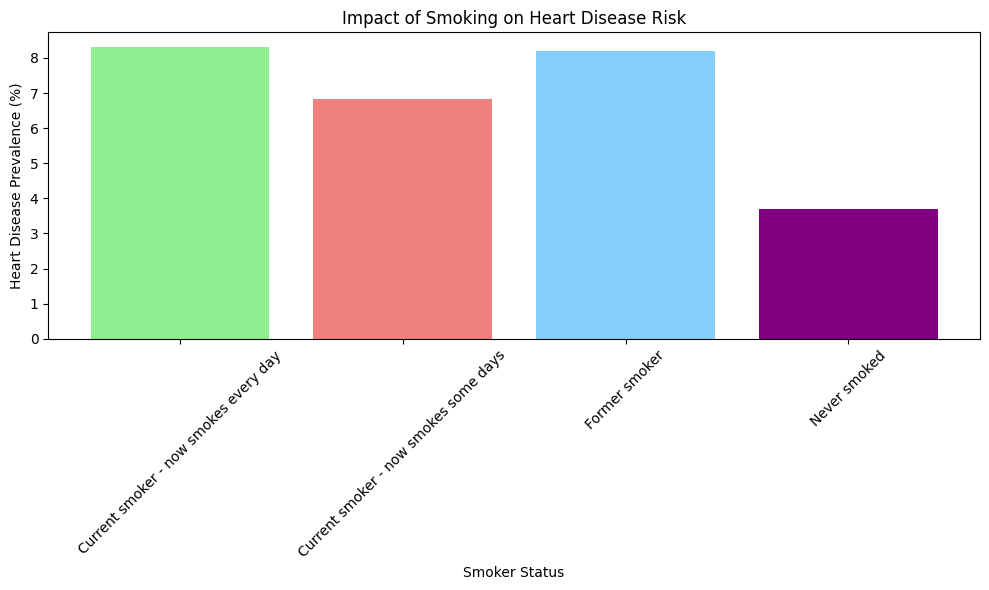

In [50]:
# Convert the Spark DataFrame to a Pandas DataFrame
smoking_risk_pd = smoking_risk.toPandas()

import matplotlib.pyplot as plt

# Set up the matplotlib figure
plt.figure(figsize=(10, 6))

# Define colors for each category
colors = ['lightgreen', 'lightcoral', 'lightskyblue', 'purple']  # Add more colors if needed

# Create a bar plot with custom colors
plt.bar(smoking_risk_pd['SmokerStatus'], smoking_risk_pd['HeartDiseasePrevalence'], color=colors)

# Add labels and title
plt.xlabel('Smoker Status')
plt.ylabel('Heart Disease Prevalence (%)')
plt.title('Impact of Smoking on Heart Disease Risk')

# Improve layout
plt.xticks(rotation=45)  # Rotate labels to improve readability
plt.tight_layout()

# Show the plot
plt.show()




In [40]:
# 6. Is having diabetes an indication of heart disease?

# SQL query for diabetes and heart disease correlation
sql_query_diabetes = """
SELECT HadDiabetes,
       AVG(CASE WHEN HadHeartAttack = 1 THEN 1 ELSE 0 END) * 100 AS HeartDiseasePrevalence
FROM HeartData
GROUP BY HadDiabetes
ORDER BY HadDiabetes;
"""

# Execute the SQL query
diabetes_risk = spark.sql(sql_query_diabetes)

# Show the results in a table format
diabetes_risk.show()



+-----------+----------------------+
|HadDiabetes|HeartDiseasePrevalence|
+-----------+----------------------+
|          0|     4.137901785503914|
|          1|     13.76393694732795|
+-----------+----------------------+



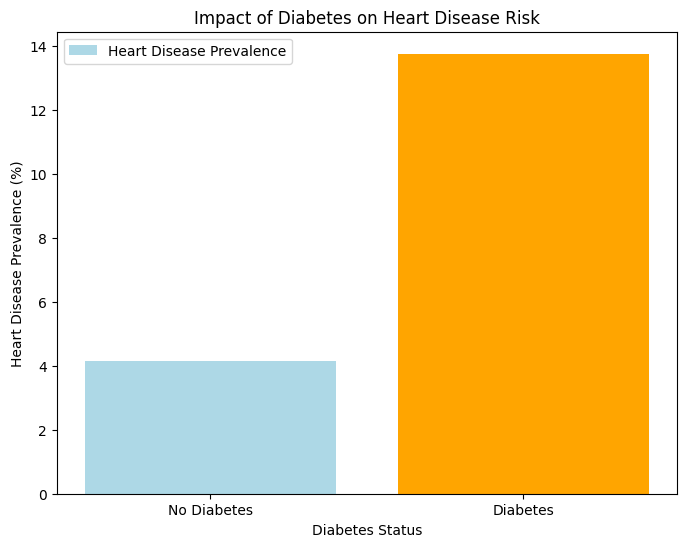

In [45]:
# Convert the Spark DataFrame to a Pandas DataFrame for easier plotting
diabetes_risk_pd = diabetes_risk.toPandas()

# Plotting the results using Matplotlib
import matplotlib.pyplot as plt

# Set up the figure and axes
plt.figure(figsize=(8, 6))
ax = plt.gca()

# Plot the stacked bar chart
ax.bar(diabetes_risk_pd['HadDiabetes'], diabetes_risk_pd['HeartDiseasePrevalence'], color=['lightblue', 'orange'], label='Heart Disease Prevalence')

# Add labels and title
plt.xlabel('Diabetes Status')
plt.ylabel('Heart Disease Prevalence (%)')
plt.title('Impact of Diabetes on Heart Disease Risk')

# Customize x-axis labels
plt.xticks([0, 1], ['No Diabetes', 'Diabetes'])

# Add legend
plt.legend()

# Show plot
plt.show()


In [44]:
# 8. Does having teeth removed indicate a higher risk of heart disease?

# SQL query for teeth removal and heart disease correlation
sql_query_teeth = """
SELECT RemovedTeeth,
       AVG(CASE WHEN HadHeartAttack = 1 THEN 1 ELSE 0 END) * 100 AS HeartDiseasePrevalence
FROM HeartData
GROUP BY RemovedTeeth
ORDER BY RemovedTeeth;
"""

# Execute the SQL query
teeth_risk = spark.sql(sql_query_teeth)

# Show the results in a table format
teeth_risk.show()


+--------------------+----------------------+
|        RemovedTeeth|HeartDiseasePrevalence|
+--------------------+----------------------+
|              1 to 5|     5.835185135605473|
|6 or more, but no...|    11.579961464354529|
|                 All|    16.707795035563944|
|        None of them|    2.8641558757371266|
+--------------------+----------------------+



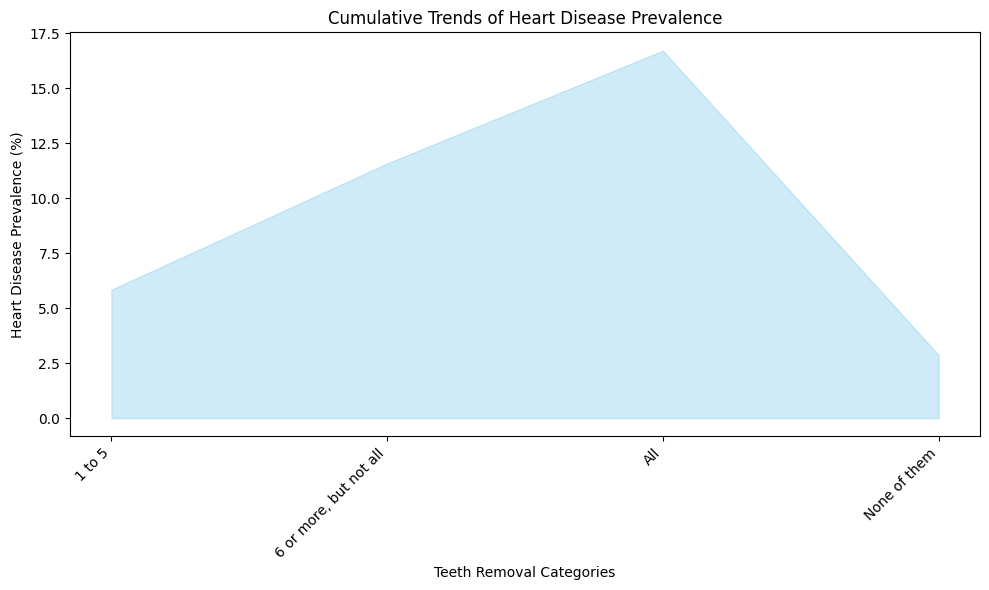

In [61]:
import matplotlib.pyplot as plt

# Extracting data from the DataFrame
teeth_categories = teeth_risk.select("RemovedTeeth").rdd.flatMap(lambda x: x).collect()
heart_disease_prevalence = teeth_risk.select("HeartDiseasePrevalence").rdd.flatMap(lambda x: x).collect()

# Create the area plot
plt.figure(figsize=(10, 6))
plt.fill_between(teeth_categories, heart_disease_prevalence, color='skyblue', alpha=0.4)

# Adding labels and title
plt.xlabel('Teeth Removal Categories')
plt.ylabel('Heart Disease Prevalence (%)')
plt.title('Cumulative Trends of Heart Disease Prevalence')

# Display the plot
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()
